#### `Import Necessary Libraries `

In [3]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input, Lambda, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import cv2
import os

import warnings
warnings.filterwarnings('ignore')

#### `The DataLoader class handles the loading, shuffling, preprocessing, and batching of image pairs`

In [28]:
class DataLoader:
    def __init__(self, dataset, batch_size, dir, shuffle=True, rotate=True): 
        self.dataset = dataset
        self.batch_size = batch_size
        self.dir = dir
        self.shuffle = shuffle
        self.rotate = rotate

    def shuffle_data(self):
        return self.dataset.sample(frac=1)
        
    def preprocess_image(self, img_path):
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")
            return None
    
        img = tf.io.read_file(img_path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.image.resize(img, (150, 150))
        #random rotation
        if self.rotate:
            random_choice = tf.random.uniform([], minval=0, maxval=2, dtype=tf.int32)
            k = 1 if random_choice == 1 else 3 
            img = tf.image.rot90(img, k=k)
            
        img = tf.image.random_brightness(img, max_delta=0.2)
        
        #detect the edges of the strokes in a signature
        img_np = img.numpy().astype('uint8') 
        img_cv2 = cv2.Canny(img_np, 30, 220) 
        #normalize
        img_cv2 = tf.cast(img_cv2, tf.float32) / 255.0
    
        return img_cv2
       
    def datagen(self):      
        num_samples = len(self.dataset)  
        while True:
            if self.shuffle:  
                self.dataset = self.shuffle_data()

            for batch in range(0, num_samples, self.batch_size):
                #extract batch of image file paths and labels
                image1_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 0]]
                image2_batch_samples = [self.dir + "/" + img for img in self.dataset.iloc[batch:batch + self.batch_size, 1]]
                label_batch_samples = self.dataset.iloc[batch:batch + self.batch_size, 2]
                
                Image1, Image2, Label = [], [], []

                #preprocess and add to the list
                for image1, image2, label in zip(image1_batch_samples, image2_batch_samples, label_batch_samples):
                    image1_data = self.preprocess_image(image1)
                    image2_data = self.preprocess_image(image2) 
                    
                    Image1.append(image1_data)
                    Image2.append(image2_data)
                    Label.append(label)
                    
                #convert the lists into numpy arrays and yield the batch
                if Image1 and Image2: 
                    Image1 = np.asarray(Image1)
                    Image2 = np.asarray(Image2)
                    Label = np.asarray(Label)
    
                    yield {"image1": Image1, "image2": Image2}, Label

    def show_preprocessed(self, batch_size=5):
        shuffled_dataset = self.shuffle_data().iloc[:batch_size]
        image1_batch_samples = [self.dir + "/" + img for img in shuffled_dataset.iloc[:, 0]]
        image2_batch_samples = [self.dir + "/" + img for img in shuffled_dataset.iloc[:, 1]]
        label_batch_samples = shuffled_dataset.iloc[:, 2]
        
        for i, (image1, image2, label) in enumerate(zip(image1_batch_samples, image2_batch_samples, label_batch_samples)):
            image1_data = self.preprocess_image(image1)
            image2_data = self.preprocess_image(image2)

            print(f"Pair {i + 1}:")
            print("Label:", label)
            print(f"Image 1 path: {image1}")
            print(f"Image 2 path: {image2}")

            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(image1_data, cmap='gray')  
            plt.title('Image 1')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(image2_data, cmap='gray') 
            plt.title('Image 2')
            plt.axis('off')
            
            plt.show()  


#### `Load Dataset`

In [65]:
train_dataset = pd.read_csv("train_data.csv",  header = None)
train_dir ="train\\"

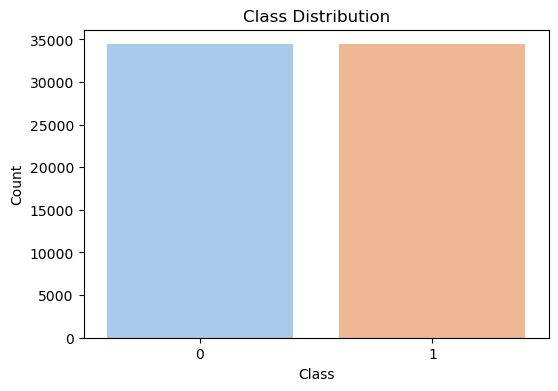

In [51]:
#plot dataset to see if balanced

target_column = train_dataset[2]
plt.figure(figsize=(6,4))
sns.countplot(x=target_column, palette="pastel")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

Pair 1:
Label: 0
Image 1 path: \Users\kathl\OneDrive\Documents\Thesis\test/08/08_04.png
Image 2 path: \Users\kathl\OneDrive\Documents\Thesis\test/08_forg/08_06.png


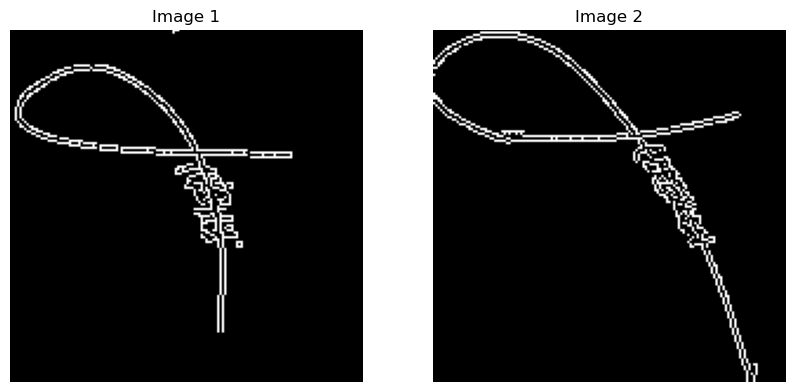

Pair 2:
Label: 1
Image 1 path: \Users\kathl\OneDrive\Documents\Thesis\test/08/08_02.png
Image 2 path: \Users\kathl\OneDrive\Documents\Thesis\test/08/08_03.png


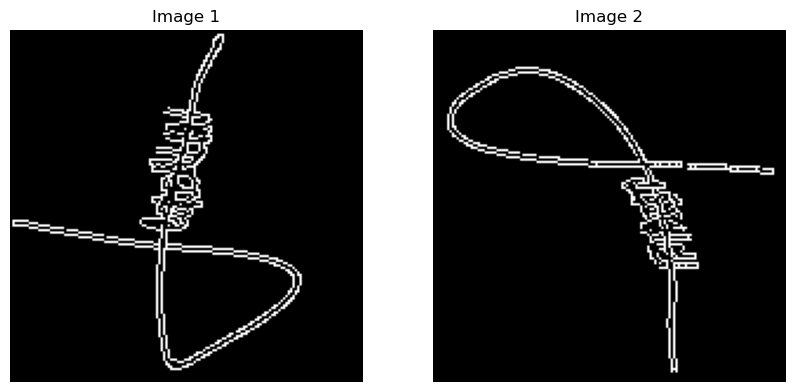

Pair 3:
Label: 0
Image 1 path: \Users\kathl\OneDrive\Documents\Thesis\test/05/05_04.png
Image 2 path: \Users\kathl\OneDrive\Documents\Thesis\test/05_forg/05_01.png


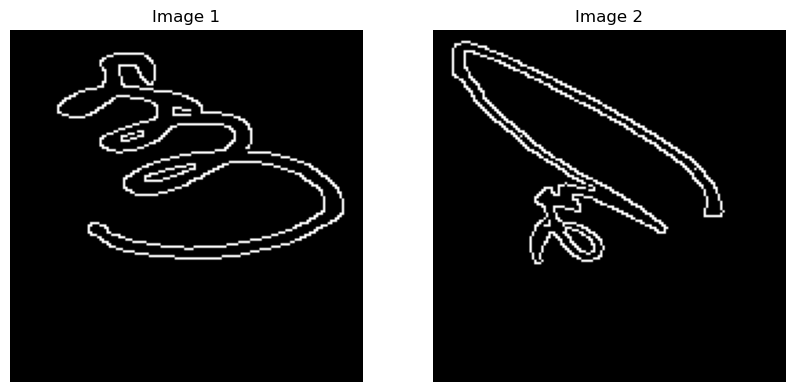

Pair 4:
Label: 1
Image 1 path: \Users\kathl\OneDrive\Documents\Thesis\test/09/09_04.png
Image 2 path: \Users\kathl\OneDrive\Documents\Thesis\test/09/09_01.png


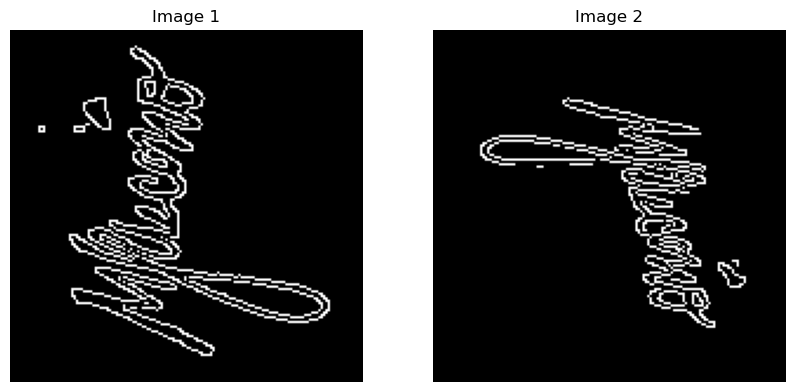

Pair 5:
Label: 1
Image 1 path: \Users\kathl\OneDrive\Documents\Thesis\test/08/08_03.png
Image 2 path: \Users\kathl\OneDrive\Documents\Thesis\test/08/08_02.png


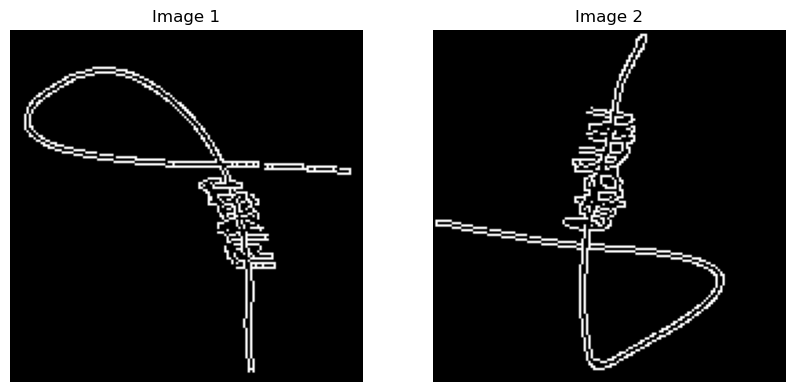

In [67]:
#split dataset
train_set, val_set = train_test_split(train_dataset, test_size=0.2, stratify=train_dataset.iloc[:, 2], random_state=42)

batch_size = 32
train_gen = DataLoader(train_set, batch_size, train_dir, shuffle = True, rotate=True) 
val_gen = DataLoader(val_set, batch_size, train_dir, shuffle = True, rotate=True) 

#show sample preprocessed images
train_gen.show_preprocessed()

#### `Build Siamese Neural Network (SNN) Model`

In [16]:
def SNN(input_shape):
    import tensorflow as tf
    model = Sequential()
    l2_reg = regularizers.l2(0.001)
    
    model.add(Conv2D(16, (3, 3), kernel_regularizer=l2_reg, input_shape=input_shape))
    model.add(LeakyReLU(alpha=0.03))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25)) 
    
    model.add(Conv2D(32, (3, 3), kernel_regularizer=l2_reg))
    model.add(LeakyReLU(alpha=0.03))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), kernel_regularizer=l2_reg))
    model.add(LeakyReLU(alpha=0.03))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3)) 
    
    model.add(Conv2D(128, (3, 3), kernel_regularizer=l2_reg))
    model.add(LeakyReLU(alpha=0.03))
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(64, kernel_regularizer=l2_reg))
    model.add(LeakyReLU(alpha=0.03))
    model.add(Dropout(0.3)) 
    
    model.add(Dense(32, kernel_regularizer=l2_reg))
    model.add(LeakyReLU(alpha=0.03))

    # Inputs and Output
    input1 = Input(input_shape, name="image1")
    input2 = Input(input_shape, name="image2")

    embedding1 = model(input1)
    embedding2 = model(input2)
    
    manhattan_distance_layer = Lambda(manhattan_distance)([embedding1, embedding2])
    output = Dense(1, activation='sigmoid')(manhattan_distance_layer)

    return Model(inputs=[input1, input2], outputs=output)
    
#computes distances between two embeddings
def manhattan_distance(embeddings): 
    import tensorflow as tf
    embedding1, embedding2 = embeddings
    return tf.abs(embedding1 - embedding2)


In [60]:
input_shape = (150, 150, 1)
model = SNN(input_shape)
model.summary()

model.compile(
    loss= "binary_crossentropy",
    optimizer = Adam(learning_rate=0.0001),
    metrics=['accuracy' ]
)

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image1 (InputLayer) │ (None, 150, 150,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image2 (InputLayer) │ (None, 150, 150,  │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32)        │    500,704 │ image1[0][0],     │
│ (Sequential)        │                   │            │ image2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 32)        │          0 │ sequential_1[0][… │
│                     │                   │            │ sequential_1[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         33 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 500,737 (1.91 MB)

 Trainable params: 500,737 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

#### `Train the Model`

In [63]:
# Callbacks
checkpoint = ModelCheckpoint("unique.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')  
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

callbacks_list = [checkpoint, early_stopping]

In [66]:
#training
history = model.fit(
        x=train_gen.datagen(),
        steps_per_epoch=len(train_set) // batch_size,
        epochs=100,        
        validation_data=val_gen.datagen(),
        validation_steps=len(val_set) // batch_size,
        callbacks=callbacks_list
)

Epoch 1/100
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step - accuracy: 0.5082 - loss: 0.9479
Epoch 1: val_loss improved from inf to 0.79458, saving model to unique.keras
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 1585s 919ms/step - accuracy: 0.5082 - loss: 0.9479 - val_accuracy: 0.5608 - val_loss: 0.7946
Epoch 2/100
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 0s 747ms/step - accuracy: 0.5359 - loss: 0.7716
Epoch 2: val_loss improved from 0.79458 to 0.72537, saving model to unique.keras
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 1575s 916ms/step - accuracy: 0.5359 - loss: 0.7716 - val_accuracy: 0.5677 - val_loss: 0.7254
Epoch 3/100
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.5490 - loss: 0.7215
Epoch 3: val_loss improved from 0.72537 to 0.70488, saving model to unique.keras
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 1608s 935ms/step - accuracy: 0.5490 - loss: 0.7215 - val_accuracy: 0.5742 - val_loss: 0.7049
Epoch 4/100
1720/1720 ━━━━━━━━━━━━━━━━━━━━ 0s 770ms/step - accuracy: 0.5626 - loss: 0.7036
Epoch 4: val_loss improve

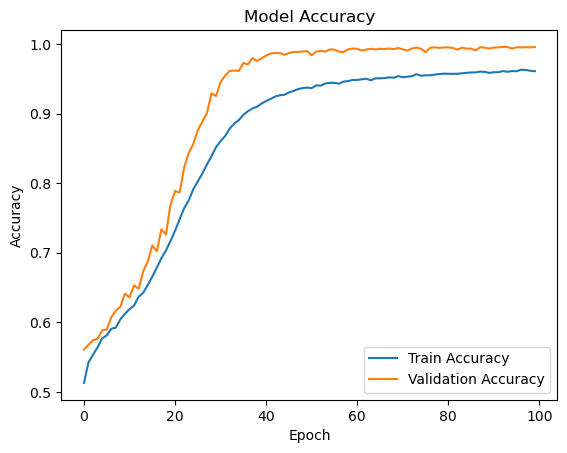

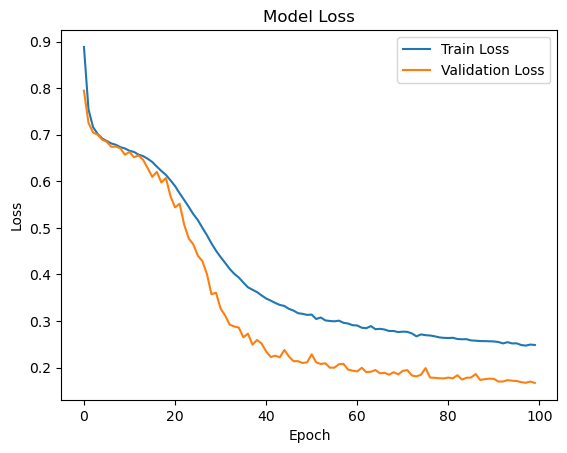

In [70]:
#plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

#plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

## `Test the Model`

In [18]:
#load trained model
import keras

trained_model = keras.saving.load_model("unique.keras",  custom_objects={'manhattan_distance': manhattan_distance}, compile=True, safe_mode=False)

In [72]:
#load test dataset
test_set = pd.read_csv("\\Users\\kathl\\OneDrive\\Documents\\Thesis\\test700.csv",  header = None)
test_dir="\\Users\\kathl\\OneDrive\\Documents\\Thesis\\test"
batch_size =8
steps = len(test_set) // batch_size
if len(test_set) % batch_size != 0:
    steps += 1
test_gen = DataLoader(test_set, batch_size, test_dir, shuffle=False, rotate = False)


In [114]:
#evaluate model with test_set
trained_model.evaluate(test_gen.datagen(), steps=len(test_set) // batch_size)

87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 498ms/step - accuracy: 0.8476 - loss: 0.5464


[0.6077642440795898, 0.8146551847457886]

In [115]:
#predict test_set
predict = trained_model.predict(test_gen.datagen(), steps=steps)

if predict.ndim > 1:
    predict = predict[:, 0]

labels = test_set.iloc[:, 2].values 
threshold = 0.5
predictions = (predict > threshold).astype(int)

precision_value = precision_score(labels, predictions, zero_division=0)
recall_value = recall_score(labels, predictions, zero_division=0)
f1_value = f1_score(labels, predictions, zero_division=0)
accuracy_value = accuracy_score(labels, predictions)

print(f'Precision: {precision_value:.4f}')
print(f'Recall: {recall_value:.4f}')
print(f'F1 Score: {f1_value:.4f}')
print(f'Accuracy: {accuracy_value:.4f}')

for i, (prediction, label) in enumerate(zip(predict, labels)):
    print(f'y_pred: {prediction:.4f}, y_true: {label}')


88/88 ━━━━━━━━━━━━━━━━━━━━ 43s 489ms/step
Precision: 0.8141
Recall: 0.8257
F1 Score: 0.8199
Accuracy: 0.8186
y_pred: 0.3883, y_true: 0
y_pred: 0.3685, y_true: 0
y_pred: 0.0054, y_true: 0
y_pred: 0.0505, y_true: 0
y_pred: 0.6930, y_true: 0
y_pred: 0.3669, y_true: 0
y_pred: 0.3379, y_true: 0
y_pred: 0.3259, y_true: 0
y_pred: 0.0049, y_true: 0
y_pred: 0.0281, y_true: 0
y_pred: 0.0136, y_true: 0
y_pred: 0.0004, y_true: 0
y_pred: 0.2304, y_true: 0
y_pred: 0.4522, y_true: 0
y_pred: 0.0112, y_true: 0
y_pred: 0.5501, y_true: 0
y_pred: 0.0274, y_true: 0
y_pred: 0.3947, y_true: 0
y_pred: 0.0395, y_true: 0
y_pred: 0.0020, y_true: 0
y_pred: 0.4076, y_true: 0
y_pred: 0.4801, y_true: 0
y_pred: 0.0183, y_true: 0
y_pred: 0.0954, y_true: 0
y_pred: 0.0466, y_true: 0
y_pred: 0.0091, y_true: 0
y_pred: 0.3931, y_true: 0
y_pred: 0.0322, y_true: 0
y_pred: 0.2865, y_true: 0
y_pred: 0.0838, y_true: 0
y_pred: 0.0004, y_true: 0
y_pred: 0.0046, y_true: 0
y_pred: 0.3266, y_true: 0
y_pred: 0.0693, y_true: 0
y_pred:

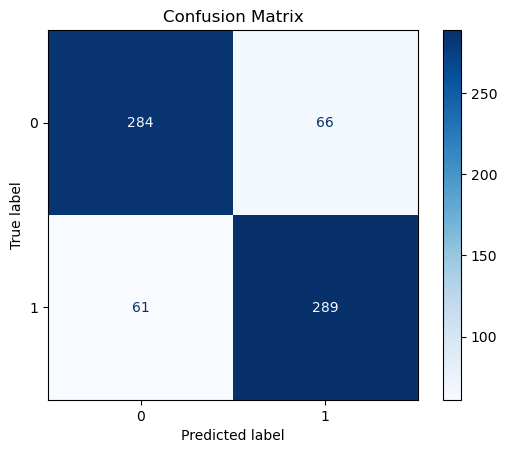

In [117]:
#plot confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()